In [1]:
import os
import time
import warnings
import numpy as np
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
def clear_file(file_path):
    with open(file_path, 'w') as _:
        pass

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

create_folder('results')

Folder 'results' already exists.


In [3]:
output_file = 'results/output.txt'
clear_file(output_file)

def print_and_write(*args, **kwargs):
    with open(output_file, 'a') as append_to_file:
        __builtins__.print(*args, **kwargs, file=append_to_file)
        __builtins__.print(*args, **kwargs)

print = print_and_write

You are given a data-set in the file A2Q2Data_train.csv with 10000 points in ($\mathbb{R}^{100}$, $\mathbb{R}$). Each row corresponds to a datapoint where the first 100 components are features and the last component is the associated y value.

In [4]:
train_file = 'A2Q2Data_train.csv'
train_data = np.genfromtxt(train_file, delimiter=',')

X_train = train_data[:, :-1]
y_train = train_data[:, -1]

print('Training dataset  ####################')
print('Shape of Feature matrix: {}'.format(X_train.shape))
print('Shape of Value vector: {}\n'.format(y_train.shape))

Training dataset  ####################
Shape of Feature matrix: (10000, 100)
Shape of Value vector: (10000,)



In [5]:
max_iterations = 2000
w_init = np.zeros(X_train.shape[1])

In [6]:
class Regression:
    def __init__(self, X, y, regression='Least Square', learning_rate=1e-6, max_iterations=max_iterations,
                 threshold_relative_error=1e-10, batch_size=None, lambda_ridge=0.1):
        self.X = X
        self.y = y
        self.regression = regression
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.threshold_relative_error = threshold_relative_error
        self.batch_size = batch_size if batch_size is not None else X.shape[0]
        self.lambda_ridge = lambda_ridge

    def update_learning_rate(self, new_learning_rate):
        self.learning_rate = new_learning_rate

    def update_lambda(self, new_lambda):
        self.lambda_ridge = new_lambda

    def analytical_solution(self):
        if self.regression == 'Least Square':
            return np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
        elif self.regression == 'Ridge':
            I = np.eye(self.X.shape[1])
            return np.linalg.inv(self.X.T @ self.X + self.lambda_ridge * I) @ self.X.T @ self.y

    def compute_gradient(self, w, batch_X, batch_y):
        if self.regression == 'Least Square':
            return -2 * batch_X.T @ (batch_y - batch_X @ w)
        elif self.regression == 'Ridge':
            I = np.eye(self.X.shape[1])
            return -2 * batch_X.T @ (batch_y - batch_X @ w) + 2 * self.lambda_ridge * I @ w

    def compute_loss(self, w):
        return np.linalg.norm(self.X @ w - self.y, ord=2) ** 2 / self.X.shape[0]

    def update_weights(self, w, gradient):
        return w - self.learning_rate * gradient

    def train(self, w_init, verbose=True):
        w = w_init
        w_analytical = self.analytical_solution()
        norm_diff = []
        loss = []
        indices = np.arange(self.X.shape[0])
        start_time = time.process_time()
        for epoch in range(self.max_iterations):
            np.random.shuffle(indices)
            shuf_X = self.X[indices]
            shuf_y = self.y[indices]
            batch_X = shuf_X[:self.batch_size]
            batch_y = shuf_y[:self.batch_size]
            gradient = self.compute_gradient(w, batch_X, batch_y)
            w = self.update_weights(w, gradient)
            norm_diff.append(np.linalg.norm(w - w_analytical, ord=2))

            epoch_loss = self.compute_loss(w)
            loss.append(epoch_loss)
            if verbose and (epoch<10 or (epoch+1)%100 == 0):
                print('Epoch: {}, Learning Rate: {}, Loss: {}, Norm Difference: {}'.format(epoch+1, self.learning_rate, epoch_loss, norm_diff[-1]))
            if epoch_loss < self.threshold_relative_error:
                break

        if verbose:
            end_time = time.process_time()
            cpu_time = end_time - start_time
            print(f"CPU time taken for training: {cpu_time} seconds")

        return w, norm_diff, loss

    def predict(self, X_test, w):
        y_pred = X_test @ w
        return y_pred

    def compute_test_loss(self, X_test, y_test, w):
        test_loss = np.linalg.norm(X_test @ w - y_test, ord=2) ** 2 / X_test.shape[0]
        return test_loss

    def plot_norm_diff(self, norm_diff, filename=None):
        plt.figure()
        plt.plot(range(len(norm_diff)), norm_diff, color='red')
        plt.xlabel('Iteration (t)')
        if self.regression == 'Least Square':
            plt.ylabel('||wt - wML||')
        else:
            plt.ylabel('||wt - wR||')

        if filename:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
        else:
            plt.show()

    def plot_loss(self, loss, filename=None):
        plt.figure()
        plt.plot(range(len(loss)), loss, color='blue')
        plt.xlabel('Iteration (t)')
        plt.ylabel('MSE')
        plt.ylim(0, 1)
        if filename:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
        else:
            plt.show()

1. Obtain the least squares solution $\mathbf{w}_{ML}$ to the regression problem using the analytical solution.

In [7]:
leastSquareRegression = Regression(X=X_train, y=y_train, regression='Least Square')
w_ML_analytical = leastSquareRegression.analytical_solution()

print('\n########################################')
print('Maximum Likelihood Estimated Regression')
print('########################################\n')
print('Analytical Maximum Likelihood Solution  ####################')
print('Shape of  wML: {}'.format(w_ML_analytical.shape))
print('wML (Analytical): ')
print(w_ML_analytical, '\n')


########################################
Maximum Likelihood Estimated Regression
########################################

Analytical Maximum Likelihood Solution  ####################
Shape of  wML: (100,)
wML (Analytical): 
[-7.84961009e-03 -1.36715320e-02 -3.61656438e-03  2.64909160e-03
  1.88551446e-01  2.65314657e-03  9.46531786e-03  1.79809481e-01
  3.73757317e-03  4.99608944e-01  8.35836265e-03  4.29108775e-03
  1.42141179e-02  3.94232414e-03  9.36795890e-03 -1.12038274e-03
  3.35727500e-03  1.16152212e-03 -9.40884707e-03 -2.45575476e-03
 -1.17409629e-02 -1.01960612e-02  7.95771321e-03 -1.00574854e-02
  6.04882939e-03 -4.67345192e-03 -3.09091547e-03  8.14909193e-03
  1.20264599e-02 -6.82458163e-03 -8.65405539e-03  9.86273479e-04
  4.92968011e-03  5.99772461e-03 -1.34667860e-02  1.07075729e-03
  1.32745992e-02 -1.14148742e-02 -2.01056697e-02  5.85096240e-01
  4.94483247e-04 -7.86666920e-04 -2.71926574e-03 -9.54021938e-03
 -5.44161058e-03  9.80679209e-03 -6.72540624e-03 -4.4541427

In [8]:
class HyperparameterTuning:
    def __init__(self, model, parameter_grid, cross_validation=5, verbose=False):
        self.model = model
        self.parameter_grid = parameter_grid
        self.cross_validation = cross_validation
        self.optimum_parameters_ = None
        self.optimum_loss_ = None
        self.avg_losses_ = None
        self.verbose=verbose

    def fit(self, X_train, y_train):
        optimum_loss = float('inf')
        optimum_parameters = None

        # Generate all possible parameter combinations
        parameter_combinations = self._generate_parameter_combinations()

        # Perform cross-validation
        avg_losses = []
        for parameters in parameter_combinations:
            losses = []

            if not self.verbose:
                norm_diffs = []
            for train_indices, val_indices in self._get_cross_validation_indices(X_train):
                X_train_fold, y_train_fold = X_train[train_indices], y_train[train_indices]
                X_val_fold, y_val_fold = X_train[val_indices], y_train[val_indices]

                # Train model with current parameters
                model_instance = self.model(X_train_fold, y_train_fold, **parameters)
                if self.verbose:
                    w = model_instance.analytical_solution()
                else:
                    w, norm_diff, _ = model_instance.train(w_init=w_init, verbose=False)
                    norm_diffs.append(norm_diff)

                # Evaluate model
                loss = model_instance.compute_test_loss(X_val_fold, y_val_fold, w)
                losses.append(loss)

            # Calculate average loss across all folds
            avg_loss = np.mean(losses)
            avg_losses.append(avg_loss)

            if self.verbose:
                print('Lambda: {}, Loss: {}'.format(parameters['lambda_ridge'], avg_loss))

            else:
                avg_norm_diff = np.mean(norm_diffs)
                print('Learning Rate: {}, Loss: {}, Norm Difference: {}'.format(parameters['learning_rate'], avg_loss, avg_norm_diff))

            # Update optimum loss and parameters if current loss is less
            if avg_loss < optimum_loss:
                optimum_parameters = parameters
                optimum_loss = avg_loss

                self.optimum_parameters_ = optimum_parameters
                self.optimum_loss_ = optimum_loss

            self.avg_losses_ = avg_losses

    def _generate_parameter_combinations(self):
        # Generate all possible parameter combinations
        keys, values = zip(*self.parameter_grid.items())
        parameter_combinations = [dict(zip(keys, v)) for v in product(*values)]
        return parameter_combinations

    def _get_cross_validation_indices(self, X_train):
        # Generate indices for cross-validation folds
        num_samples = len(X_train)
        fold_size = num_samples // self.cross_validation
        indices = np.arange(num_samples)
        for i in range(self.cross_validation):
            val_indices = indices[i*fold_size:(i+1)*fold_size]
            train_indices = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
            yield train_indices, val_indices

2. Code the gradient descent algorithm with suitable step size to solve the least squares algorithms and plot $||\mathbf{w}^t - \mathbf{w}_{ML}||_2$ as a function of $t$. What do you observe?

Tuning Learning rate for batch mode of gradient descent in maximum likelihood estimation:


Learning Rate: 5e-08, Loss: 0.19395063147037228, Norm Difference: 1.4627443028608227
Learning Rate: 1e-07, Loss: 0.15848134390210555, Norm Difference: 1.3722980065796149
Learning Rate: 5e-07, Loss: 0.05530450867885704, Norm Difference: 0.8706861317075958
Learning Rate: 1e-06, Loss: 0.041757381889203936, Norm Difference: 0.5556253780390125
Learning Rate: 3e-06, Loss: 0.04065692827650064, Norm Difference: 0.20097954639772547
Learning Rate: 3.5e-06, Loss: 0.040657556384647804, Norm Difference: 0.17224777718459325
Learning Rate: 3.75e-06, Loss: 0.04065769614442924, Norm Difference: 0.16073405073240019
Learning Rate: 4e-06, Loss: 0.0406577775250922, Norm Difference: 0.15065635649158507
Learning Rate: 5e-06, Loss: 593275867149933.1, Norm Difference: 158874.5139436548
Learning Rate: 1e-05, Loss: nan, Norm Difference: nan
Learning Rate: 5e-05, Loss: nan, Norm Difference: nan

Optimal Learning Rate: 3e-06
Epoch: 1, Learning Rate: 3e-06, Loss: 1.494283789272762, Norm Difference: 1.56825638515424

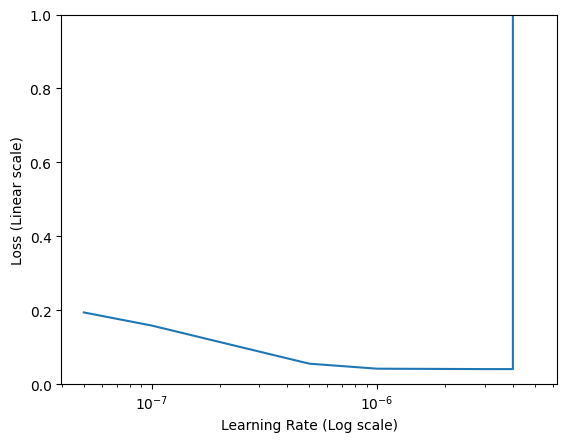

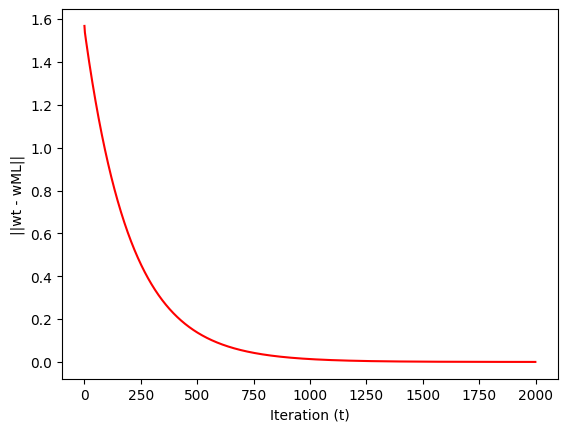

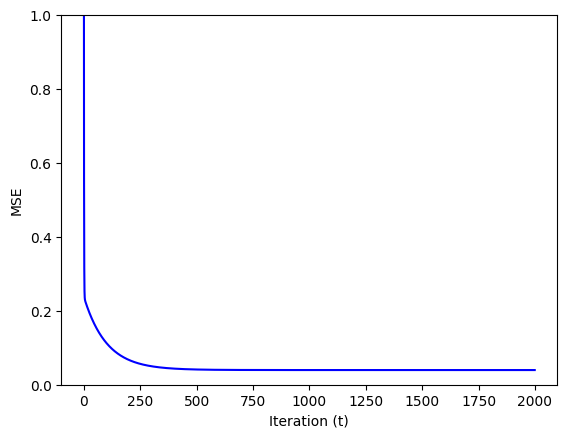

In [9]:
learning_rate_values = np.array([5e-8, 1e-7, 5e-7, 1e-6, 3e-6, 3.5e-6, 3.75e-6, 4e-6, 5e-6, 1e-5, 5e-5])
parameter_grid = {
    'learning_rate': learning_rate_values,
    'regression': ['Least Square']
}

print('Tuning Learning rate for batch mode of gradient descent in maximum likelihood estimation:')
hyperparameterTuningBatch = HyperparameterTuning(Regression, parameter_grid)
hyperparameterTuningBatch.fit(X_train, y_train)
losses = hyperparameterTuningBatch.avg_losses_

learning_rate_batch = hyperparameterTuningBatch.optimum_parameters_['learning_rate']
print(f'\nOptimal Learning Rate: {learning_rate_batch}')

plt.figure()
plt.semilogx(learning_rate_values, losses)
plt.xlabel('Learning Rate (Log scale)')
plt.ylabel('Loss (Linear scale)')
plt.ylim(0, 1)
plt.savefig('results/lr-batch.pdf', format='pdf', bbox_inches='tight')

leastSquareRegressionBatch = Regression(X_train, y_train, regression='Least Square', learning_rate=learning_rate_batch)
w_ML_batch, norm_diff, loss = leastSquareRegressionBatch.train(w_init=w_init, verbose=True)
print('\nwML (Batch Mode of Gradient Descent):')
print(w_ML_batch, '\n')

leastSquareRegressionBatch.plot_norm_diff(norm_diff, 'results/norm-diff-batch.pdf')
leastSquareRegressionBatch.plot_loss(loss, 'results/loss-batch.pdf')

3. Code the stochastic gradient descent algorithm using batch size of 100 and plot $||\mathbf{w}^t - \mathbf{w}_{ML}||_2$ as a function of $t$. What are your observations?

Tuning Learning rate for stochastic mode (batch size: 100) of gradient descent in maximum likelihood estimation:
Learning Rate: 1e-07, Loss: 0.8994638760798525, Norm Difference: 1.5846300965505922
Learning Rate: 5e-07, Loss: 0.23397895073216834, Norm Difference: 1.5538809128966924
Learning Rate: 1e-06, Loss: 0.22751407404846988, Norm Difference: 1.5380611545150864
Learning Rate: 5e-06, Loss: 0.18422999172952143, Norm Difference: 1.4392549980802793
Learning Rate: 1e-05, Loss: 0.14385309923607614, Norm Difference: 1.3299107960558543
Learning Rate: 5e-05, Loss: 0.04856049475951542, Norm Difference: 0.7685518262084704
Learning Rate: 0.0001, Loss: 0.041048883594372816, Norm Difference: 0.46283584383044973
Learning Rate: 0.0002, Loss: 0.041220540004069835, Norm Difference: 0.25015194023462045
Learning Rate: 0.00025, Loss: 0.04110951158927316, Norm Difference: 0.20702385997578776
Learning Rate: 0.0005, Loss: nan, Norm Difference: nan
Learning Rate: 0.001, Loss: nan, Norm Difference: nan
Learn

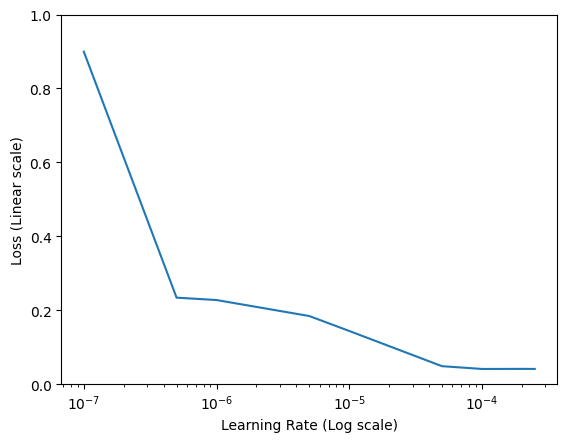

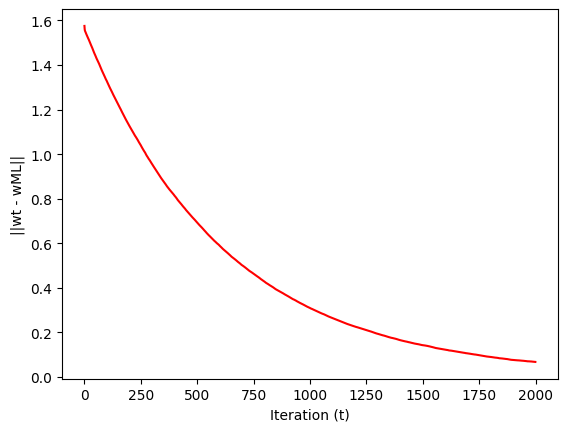

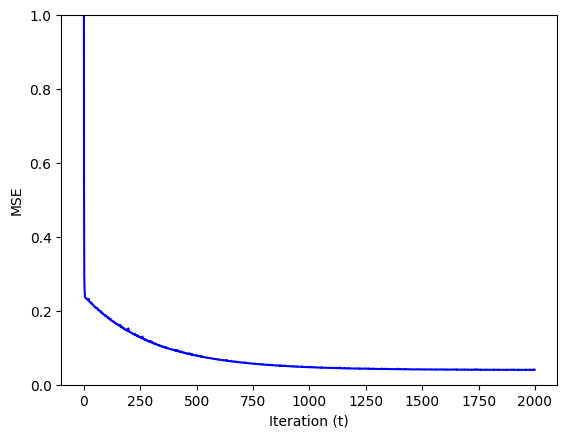

In [10]:
learning_rate_values = np.array([1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 2e-4, 2.5e-4, 5e-4, 1e-3, 5e-3, 1e-2])
batch_size = 100
parameter_grid = {
    'learning_rate': learning_rate_values,
    'regression': ['Least Square'],
    'batch_size': [batch_size]
}

print(f'Tuning Learning rate for stochastic mode (batch size: {batch_size}) of gradient descent in maximum likelihood estimation:')
hyperparameterTuningStochastic = HyperparameterTuning(Regression, parameter_grid)
hyperparameterTuningStochastic.fit(X_train, y_train)
losses = hyperparameterTuningStochastic.avg_losses_

learning_rate_stochastic = hyperparameterTuningStochastic.optimum_parameters_['learning_rate']
print(f'\n\nOptimal Learning Rate: {learning_rate_stochastic}')

plt.figure()
plt.semilogx(learning_rate_values, losses)
plt.xlabel('Learning Rate (Log scale)')
plt.ylabel('Loss (Linear scale)')
plt.ylim(0, 1)
plt.savefig('results/lr-stochastic.pdf', format='pdf', bbox_inches='tight')

leastSquareRegressionStochastic = Regression(X_train, y_train, regression='Least Square', learning_rate=learning_rate_stochastic, batch_size=batch_size)
w_ML_stochastic, norm_diff, loss = leastSquareRegressionStochastic.train(w_init=w_init, verbose=True)
print('wML (Stochastic Mode of Gradient Descent w/- batch size: {}):'.format(batch_size))
print(w_ML_stochastic, '\n')

leastSquareRegressionStochastic.plot_norm_diff(norm_diff, 'results/norm-diff-stochastic.pdf')
leastSquareRegressionStochastic.plot_loss(loss, 'results/loss-stochastic.pdf')

4. Code the gradient descent algorithm for ridge regression. Cross-validate for various choices of $\lambda$ and plot the error in the validation set as a function of $\lambda$. For the best $\lambda$ chosen, obtain $\mathbf{w}_R$. Compare the test error (for the test data in the file A2Q2Data_test.csv) of $\mathbf{w}_R$ with $\mathbf{w}_{ML}$. Which is better and why?


########################################
Ridge Regression
########################################

Tuning Lambda for Ridge Regression  ####################


Lambda: 1e-05, Loss: 0.04065788932428073
Lambda: 1.2618568830660211e-05, Loss: 0.04065788931926496
Lambda: 1.5922827933410938e-05, Loss: 0.04065788931293574
Lambda: 2.0092330025650458e-05, Loss: 0.04065788930494953
Lambda: 2.5353644939701114e-05, Loss: 0.04065788929487174
Lambda: 3.199267137797385e-05, Loss: 0.04065788928215517
Lambda: 4.037017258596558e-05, Loss: 0.04065788926610873
Lambda: 5.0941380148163754e-05, Loss: 0.04065788924586058
Lambda: 6.428073117284319e-05, Loss: 0.040657889220310446
Lambda: 8.111308307896872e-05, Loss: 0.04065788918806984
Lambda: 0.00010235310218990269, Loss: 0.04065788914738745
Lambda: 0.0001291549665014884, Loss: 0.04065788909605254
Lambda: 0.00016297508346206434, Loss: 0.04065788903127644
Lambda: 0.00020565123083486514, Loss: 0.040657888949539644
Lambda: 0.00025950242113997375, Loss: 0.040657888846402236
Lambda: 0.00032745491628777284, Loss: 0.04065788871626146
Lambda: 0.00041320124001153346, Loss: 0.040657888552048674
Lambda: 0.0005214008287999684, L

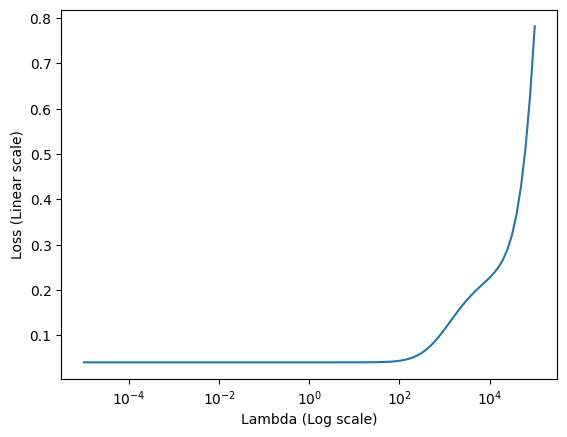

In [11]:
lambda_values = np.logspace(-5, 5, 100)
parameter_grid = {
    'lambda_ridge': lambda_values,
    'regression': ['Ridge']
}
print('\n########################################')
print('Ridge Regression')
print('########################################\n')
print(f'Tuning Lambda for Ridge Regression  ####################')
hyperparameterTuningLambda = HyperparameterTuning(Regression, parameter_grid, verbose=True)
hyperparameterTuningLambda.fit(X_train, y_train)

lambda_ridge = hyperparameterTuningLambda.optimum_parameters_['lambda_ridge']
losses = hyperparameterTuningLambda.avg_losses_

print(f'\n\nOptimal Lambda: {lambda_ridge}')

ridgeRegression = Regression(X_train, y_train, regression='Ridge', lambda_ridge=lambda_ridge)
w_R_analytical = ridgeRegression.analytical_solution()

print('Analytical Ridge Regression Solution  ####################')
print('Shape of wR: {}'.format(w_R_analytical.shape))
print('wR (Analytical):')
print(w_R_analytical, '\n')

plt.figure()
plt.semilogx(lambda_values, losses)
plt.xlabel('Lambda (Log scale)')
plt.ylabel('Loss (Linear scale)')
plt.savefig('results/ridge-lambda.pdf', format='pdf', bbox_inches='tight')

Tuning Learning rate for batch mode of gradient descent in ridge regression:


Learning Rate: 5e-08, Loss: 0.19395818570690057, Norm Difference: 1.4584811780422398
Learning Rate: 1e-07, Loss: 0.15850558338671858, Norm Difference: 1.3680624863819408
Learning Rate: 5e-07, Loss: 0.05541441262940945, Norm Difference: 0.8670476366944811
Learning Rate: 1e-06, Loss: 0.041816301521308136, Norm Difference: 0.5528625012125364
Learning Rate: 3e-06, Loss: 0.04065565296032657, Norm Difference: 0.19985011408069764
Learning Rate: 3.5e-06, Loss: 0.04065585364603134, Norm Difference: 0.17127780361134176
Learning Rate: 3.75e-06, Loss: 0.04065591000993029, Norm Difference: 0.15982843278288072
Learning Rate: 4e-06, Loss: 0.04065594539746376, Norm Difference: 0.14980723340303617
Learning Rate: 5e-06, Loss: 636880894476239.8, Norm Difference: 164257.35988578052
Learning Rate: 1e-05, Loss: nan, Norm Difference: nan
Learning Rate: 5e-05, Loss: nan, Norm Difference: nan

Optimal Learning Rate: 3e-06
Epoch: 1, Learning Rate: 3e-06, Loss: 1.4942837892727643, Norm Difference: 1.564881049227

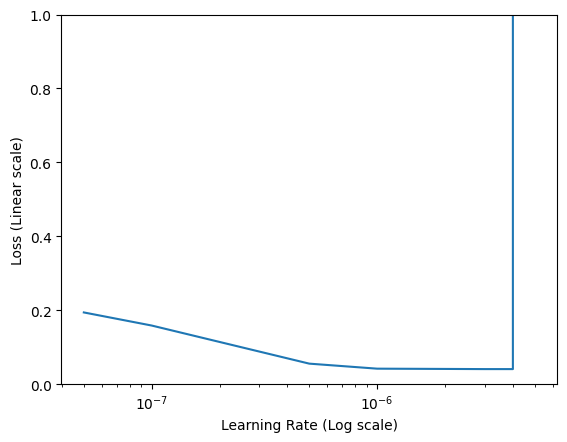

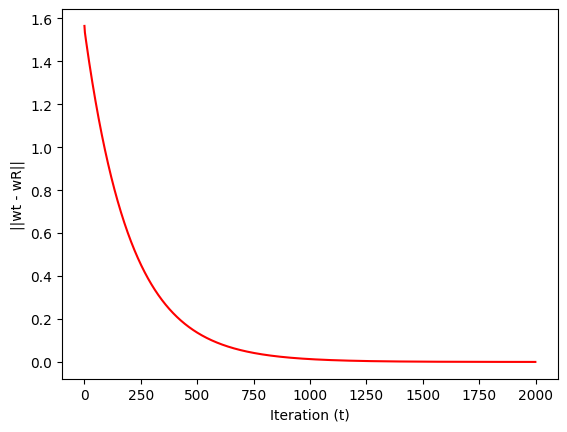

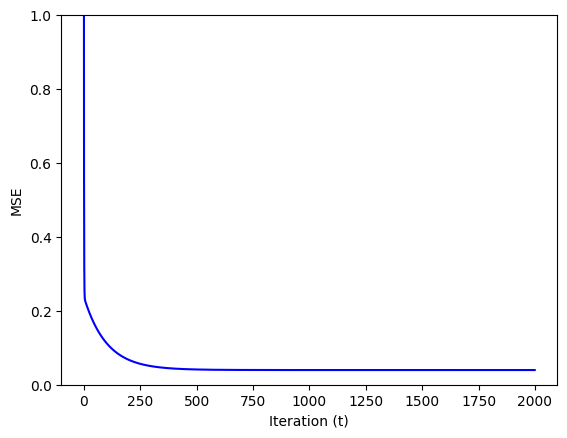

In [12]:
learning_rate_values = np.array([5e-8, 1e-7, 5e-7, 1e-6, 3e-6, 3.5e-6, 3.75e-6, 4e-6, 5e-6, 1e-5, 5e-5])
parameter_grid = {
    'learning_rate': learning_rate_values,
    'regression': ['Ridge'],
    'lambda_ridge': [lambda_ridge]
}

print('Tuning Learning rate for batch mode of gradient descent in ridge regression:')
hyperparameterTuningRidge = HyperparameterTuning(Regression, parameter_grid)
hyperparameterTuningRidge.fit(X_train, y_train)
losses = hyperparameterTuningRidge.avg_losses_

learning_rate_ridge = hyperparameterTuningRidge.optimum_parameters_['learning_rate']
print(f'\nOptimal Learning Rate: {learning_rate_ridge}')

plt.figure()
plt.semilogx(learning_rate_values, losses)
plt.xlabel('Learning Rate (Log scale)')
plt.ylabel('Loss (Linear scale)')
plt.ylim(0, 1)
plt.savefig('results/lr-ridge.pdf', format='pdf', bbox_inches='tight')

ridgeRegressionBatch = Regression(X_train, y_train, regression='Ridge', learning_rate=learning_rate_ridge, lambda_ridge=lambda_ridge)
w_R_batch, norm_diff, loss = ridgeRegressionBatch.train(w_init=w_init, verbose=True)
print('\nwR (Batch Mode of Gradient Descent):')
print(w_R_batch, '\n')

ridgeRegressionBatch.plot_norm_diff(norm_diff, 'results/norm-diff-ridge.pdf')
ridgeRegressionBatch.plot_loss(loss, 'results/loss-ridge.pdf')

In [13]:
print('\n########################################')
print('Comparison with Test data')
print('########################################\n')

test_file = 'A2Q2Data_test.csv'
test_data = np.genfromtxt(test_file, delimiter=',')

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

print('\ntesting dataset  ####################')
print('Shape of Feature matrix:', X_test.shape)
print('Shape of value vector:', y_test.shape)

print('Mean Square Error Loss computed on Test data  ####################')
test_error_ML = leastSquareRegressionBatch.compute_test_loss(X_test, y_test, w_ML_analytical)
print(f'Maximum Likelihood Estimartor (Analytical): {test_error_ML}')

test_error_ML_batch = leastSquareRegressionBatch.compute_test_loss(X_test, y_test, w_ML_batch)
print(f'Maximum Likelihood Estimartor (Batch Gradient Descent): {test_error_ML_batch}')

test_error_ML_stochastic = leastSquareRegressionBatch.compute_test_loss(X_test, y_test, w_ML_stochastic)
print(f'Maximum Likelihood Estimartor (Stochastic Gradient Descent w/- batch size of 100): {test_error_ML_stochastic}')

test_error_R = ridgeRegression.compute_test_loss(X_test, y_test, w_R_analytical)
print(f'Ridge Regression (Analytical): {test_error_R}')

test_error_R_batch = ridgeRegression.compute_test_loss(X_test, y_test, w_R_batch)
print(f'Ridge Regression (Batch Gradient Descent): {test_error_R_batch}\n')


########################################
Comparison with Test data
########################################


testing dataset  ####################
Shape of Feature matrix: (500, 100)
Shape of value vector: (500,)
Mean Square Error Loss computed on Test data  ####################
Maximum Likelihood Estimartor (Analytical): 0.37072731116979096
Maximum Likelihood Estimartor (Batch Gradient Descent): 0.37070214860750766
Maximum Likelihood Estimartor (Stochastic Gradient Descent w/- batch size of 100): 0.3580403098478923
Ridge Regression (Analytical): 0.36997126278713083
Ridge Regression (Batch Gradient Descent): 0.36994676373274016



In [14]:
print = __builtins__.print